# Time-Series kmeans

Validación cruzada...

→ Evaluando configuración: {'n_clusters': 2, 'n_init': 3, 'tol': 0.001}
  Promedios:
    Accuracy   : 0.8000
    Precision  : 0.4000
    Recall     : 0.5000
    F1 Score   : 0.4435
    ARI        : 0.0090
    Silhouette : 0.0078
    
→ Evaluando configuración: {'n_clusters': 2, 'n_init': 3, 'tol': 1e-05}
  Promedios:
    Accuracy   : 0.8000
    Precision  : 0.4000
    Recall     : 0.5000
    F1 Score   : 0.4435
    ARI        : 0.0090
    Silhouette : 0.0078
    
→ Evaluando configuración: {'n_clusters': 2, 'n_init': 3, 'tol': 1e-06}
  Promedios:
    Accuracy   : 0.8000
    Precision  : 0.4000
    Recall     : 0.5000
    F1 Score   : 0.4435
    ARI        : 0.0090
    Silhouette : 0.0078
    
→ Evaluando configuración: {'n_clusters': 2, 'n_init': 3, 'tol': 1e-07}
  Promedios:
    Accuracy   : 0.8000
    Precision  : 0.4000
    Recall     : 0.5000
    F1 Score   : 0.4435
    ARI        : 0.0090
    Silhouette : 0.0078
    
→ Evaluando configuración: {'n_clusters':

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m


====== Evaluación en train ======
Accuracy:  0.8000

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.80      1.00      0.89       320
     Clase 1       0.00      0.00      0.00        80

    accuracy                           0.80       400
   macro avg       0.40      0.50      0.44       400
weighted avg       0.64      0.80      0.71       400

F1 Score:  0.4444
ARI:       0.0011

Matriz de confusión:
[[320   0]
 [ 80   0]]

====== Evaluación en test ======
Accuracy:  0.8000

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.80      1.00      0.89        80
     Clase 1       0.00      0.00      0.00        20

    accuracy                           0.80       100
   macro avg       0.40      0.50      0.44       100
weighted avg       0.64      0.80      0.71       100

F1 Score:  0.4444
ARI:       -0.0065

Matriz de confusión:
[[80  0]
 [20  0]]


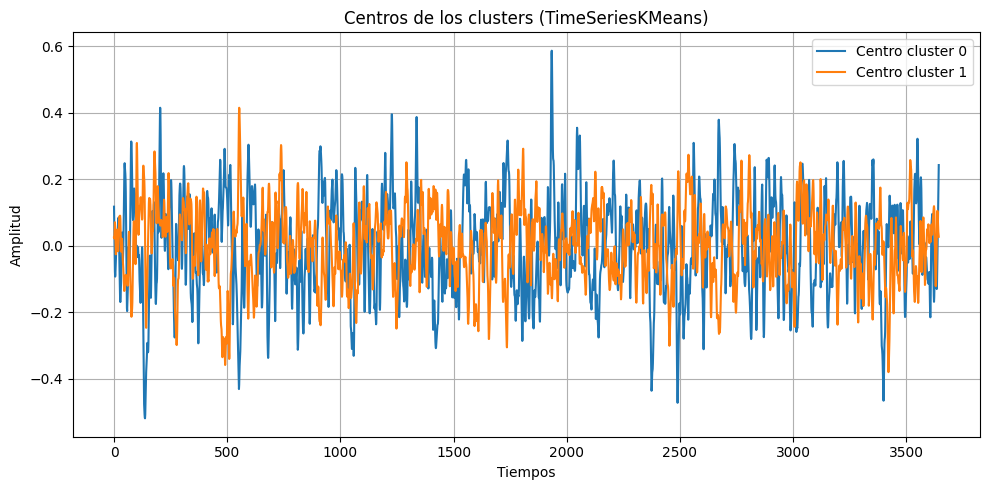

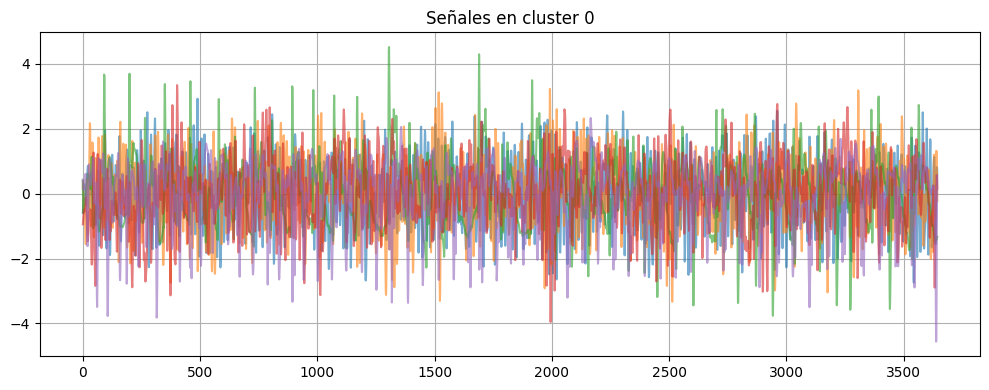

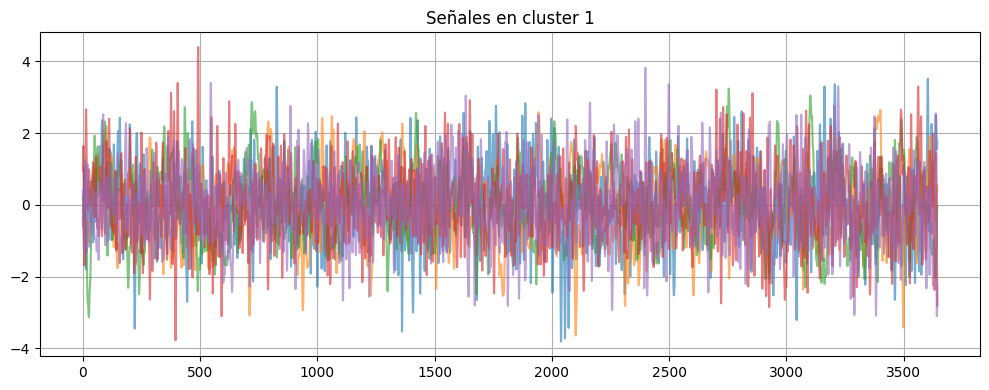

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, adjusted_rand_score, silhouette_score, classification_report
)
from scipy.signal import butter, filtfilt
from scipy.stats import mode
from joblib import Parallel, delayed

# ===================== CARGA Y PREPROCESAMIENTO =====================
# Cargar datos
data = np.loadtxt("/mnt/DGX0Raid/databases/bonn_dataset_columns_correct.csv", delimiter=",").T
X_raw = data[:, 1:]
y = data[:, 0].astype(int)

# Convertir a dataset de series temporales
X = to_time_series_dataset(X_raw)

# Dividir en train y test con stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Extraer primeros 21 segundos
def extract_21_seconds_generator(X, fs=173.61, window_duration=21):
    num_samples = int(window_duration * fs)
    for signal in X:
        yield signal[:num_samples]

X_train_extracted = np.array(list(extract_21_seconds_generator(X_train))).squeeze(-1)
X_test_extracted = np.array(list(extract_21_seconds_generator(X_test))).squeeze(-1)

# Filtro pasa bajos
def low_pass_filter(signal, cutoff=40.0, fs=173.61, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

X_train_filtered = np.array([low_pass_filter(sig) for sig in X_train_extracted])
X_test_filtered = np.array([low_pass_filter(sig) for sig in X_test_extracted])

# Escalado
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)
X_train_scaled = scaler.fit_transform(X_train_filtered)
X_test_scaled = scaler.transform(X_test_filtered)

# ===================== FUNCIÓN DE MAPEADO =====================
def map_clusters_to_labels(clusters, true_labels):
    true_labels = np.array(true_labels, dtype=int)
    label_map = {}
    for cluster in np.unique(clusters):
        mask = (clusters == cluster)
        true_mode = mode(true_labels[mask], keepdims=True).mode[0]
        label_map[cluster] = true_mode
    return np.array([label_map[c] for c in clusters]), label_map

# ===================== VALIDACIÓN CRUZADA PARALELA =====================
kf = KFold(n_splits=10, shuffle=True, random_state=42)
param_grid = {'n_clusters': [2], 'n_init': [3, 5, 6, 7, 10], 'tol': [1e-3, 1e-5, 1e-6, 1e-7, 1e-8]}

def run_kmeans_fold(fold, train_idx, val_idx, params):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = TimeSeriesKMeans(n_clusters=params['n_clusters'],
                             metric='euclidean', n_init=params['n_init'],
                             tol=params['tol'], random_state=0)
    model.fit(X_tr)

    y_val_pred = model.predict(X_val)
    mapped_val, _ = map_clusters_to_labels(y_val_pred, y_val)

    X_val_flat = X_val.squeeze()
    sil_score = silhouette_score(X_val_flat, y_val_pred)

    return {
        'config': str(params),
        'fold': fold,
        'accuracy': accuracy_score(y_val, mapped_val),
        'precision': precision_score(y_val, mapped_val, average='macro'),
        'recall': recall_score(y_val, mapped_val, average='macro'),
        'f1': f1_score(y_val, mapped_val, average='macro'),
        'ari': adjusted_rand_score(y_val, y_val_pred),
        'silhouette': sil_score
    }

fold_results = []
summary_results = []

print("Validación cruzada...\n")
for params in ParameterGrid(param_grid):
    print(f"→ Evaluando configuración: {params}")

    results = Parallel(n_jobs=40)(
        delayed(run_kmeans_fold)(fold+1, train_idx, val_idx, params)
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled))
    )

    fold_results.extend(results)

    avg_metrics = {
        'config': str(params),
        'accuracy': np.mean([r['accuracy'] for r in results]),
        'precision': np.mean([r['precision'] for r in results]),
        'recall': np.mean([r['recall'] for r in results]),
        'f1': np.mean([r['f1'] for r in results]),
        'ari': np.mean([r['ari'] for r in results]),
        'silhouette': np.mean([r['silhouette'] for r in results])
    }

    summary_results.append(avg_metrics)

    print(f"""  Promedios:
    Accuracy   : {avg_metrics['accuracy']:.4f}
    Precision  : {avg_metrics['precision']:.4f}
    Recall     : {avg_metrics['recall']:.4f}
    F1 Score   : {avg_metrics['f1']:.4f}
    ARI        : {avg_metrics['ari']:.4f}
    Silhouette : {avg_metrics['silhouette']:.4f}
    """)

summary_df = pd.DataFrame(summary_results)
all_folds_df = pd.DataFrame(fold_results)

print("\n==== Resumen final por configuración ====")
print(summary_df.sort_values(by="f1", ascending=False).round(4))

# ===================== MODELO FINAL (mejor configuración) =====================
# Convertir string a dict
best_params = eval(summary_df.sort_values(by="f1", ascending=False).iloc[0]['config'])
print(f"\n→ Entrenando modelo final con mejor configuración: {best_params}")

best_model = TimeSeriesKMeans(n_clusters=best_params['n_clusters'],
                             metric='euclidean', n_init=best_params['n_init'],
                             tol=best_params['tol'], random_state=0)
best_model.fit(X_train_scaled)

# ===================== EVALUACIÓN FINAL =====================
def evaluate_and_print(X_set, y_true, model, set_name=""):
    y_pred = model.predict(X_set)
    mapped_pred, _ = map_clusters_to_labels(y_pred, y_true)

    # Calcular métricas adicionales
    acc = accuracy_score(y_true, mapped_pred)
    prec = precision_score(y_true, mapped_pred, average='macro')
    rec = recall_score(y_true, mapped_pred, average='macro')
    f1 = f1_score(y_true, mapped_pred, average='macro')
    ari = adjusted_rand_score(y_true, y_pred)

    # Reporte de clasificación detallado
    print(f"\n====== Evaluación en {set_name} ======")
    print(f"Accuracy:  {acc:.4f}")

    # Mostrar el reporte de clasificación con las clases 0 y 1
    print("\nReporte de clasificación:")
    print(classification_report(y_true, mapped_pred, target_names=["Clase 0", "Clase 1"]))

    print(f"F1 Score:  {f1:.4f}")
    print(f"ARI:       {ari:.4f}")
    print("\nMatriz de confusión:")
    print(confusion_matrix(y_true, mapped_pred))

    return acc, prec, rec, f1, ari, mapped_pred

# Evaluación en el conjunto de entrenamiento
train_metrics = evaluate_and_print(X_train_scaled, y_train, best_model, "train")

# Evaluación en el conjunto de prueba
test_metrics = evaluate_and_print(X_test_scaled, y_test, best_model, "test")

# ===================== VISUALIZACIÓN =====================
plt.figure(figsize=(10, 5))
for i, center in enumerate(best_model.cluster_centers_):
    plt.plot(center.ravel(), label=f'Centro cluster {i}')
plt.title("Centros de los clusters (TimeSeriesKMeans)")
plt.xlabel("Tiempos")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

assignments = best_model.predict(X_train_scaled)
for cluster_id in np.unique(assignments):
    signals = X_train_scaled[assignments == cluster_id]
    plt.figure(figsize=(10, 4))
    for i in range(min(5, len(signals))):
        plt.plot(signals[i].ravel(), alpha=0.6, label=f'Señal {i+1}')
    plt.title(f"Señales en cluster {cluster_id}")
    plt.grid()
    plt.tight_layout()
    plt.show()


In [ ]:
from scipy.stats import ttest_1samp

# ===================== P-TEST F1 CONTRA OTRAS CONFIGS =====================
# Obtener la mejor configuración por f1
summary_sorted = summary_df.sort_values(by="f1", ascending=False).reset_index(drop=True)
best_config_str = summary_sorted.loc[0, "config"]
best_f1 = summary_sorted.loc[0, "f1"]

# Obtener F1 de las demás configuraciones
other_f1_scores = summary_sorted.loc[1:, "f1"].values

# Realizar test estadístico: ¿Es el mejor F1 significativamente mayor que los otros?
t_stat, p_value = ttest_1samp(other_f1_scores, popmean=best_f1)

print(f"\n===== TEST ESTADÍSTICO: ¿Mejor F1 es significativo? =====")
print(f"Mejor configuración: {best_config_str}")
print(f"F1-score de mejor modelo: {best_f1:.4f}")
print(f"F1 promedio resto configuraciones: {np.mean(other_f1_scores):.4f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("→ Resultado estadísticamente significativo (p < 0.05): la mejor configuración tiene un F1-score significativamente mayor.")
else:
    print("→ Resultado NO estadísticamente significativo (p ≥ 0.05): la mejor configuración no es significativamente mejor.")



===== TEST ESTADÍSTICO: ¿Mejor F1 es significativo? =====
Mejor configuración: {'n_clusters': 2, 'n_init': 3, 'tol': 0.001}
F1-score de mejor modelo: 0.4435
F1 promedio resto configuraciones: 0.4435
t-statistic: 4.7958
p-value: 0.0001
→ Resultado estadísticamente significativo (p < 0.05): la mejor configuración tiene un F1-score significativamente mayor.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
